# Assignment 1

# Density estimation using Real NVP

Normalizing flows are the class of probabilistic models that provides flexible parametrical probabilistic models, where the probability density function can be computed exactly. In the assignment, we will consider a real-valued non-volume preserving normalizing flows (Real NVP) -- a special case of normalizing flow.

#### Problem setting

Our goal is to training a generative network $g_\theta:  Z \rightarrow X, g = f^{-1}$ that maps latent variable $z \sim p(z)$ to a sample $x \sim p(x)$. Where $p(z)$ is a prior distibiution and $p(x)$ is a data distibution. An illustrative example is provided below. 

<img src="2d-example.png" width=600px>


#### Change of variable formula

Given an observed data variable $x \in X$,
a simple prior probability distribution $p_{Z}$ on a latent variable $z \in Z$,
and a bijection $f: X \rightarrow Z$ (with $g = f^{-1}$),
the change of variable formula defines a model distribution on $X$ by
\begin{align}
p_{X}(x) &= p_{Z}\big(f(x)\big) \left|\det\left(\cfrac{\partial f(x)}{\partial x^T} \right)\right|
\label{eq:change-variables}\\
\log\left(p_{X}(x)\right) &= \log\Big(p_{Z}\big(f(x)\big)\Big) + \log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)
,
\end{align}
where $\frac{\partial f(x)}{\partial x^T}$ is the Jacobian of $f$ at $x$.

Exact samples from the resulting distribution can be generated by using the inverse transform sampling rule. A sample $z \sim p_{Z}$ is drawn in the latent space, and its inverse image $x = f^{-1}(z) = g(z)$ generates a sample in the original space. Computing the density on a point $x$ is accomplished by computing the density of its image $f(x)$ and multiplying by the associated Jacobian determinant $\det\left(\frac{\partial f(x)}{\partial x^T}\right)$.

#### Real NVP

Real NVP presents a class of functions where $\log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)$ can be computed efficiently (see, 3.3 Properties, https://arxiv.org/abs/1605.08803). Every layer of Real NVP is a coupling layer followed by permutation layer. Combination of coupling and permutation layers can be implemented as a masked version of the coupling layer:
\begin{align}
y = b \odot x + (1 - b) \odot \Big(x \odot \exp\big(s(b \odot x)\big) + t(b \odot x)\Big),
\end{align}

where $s$ and $t$ stand for scale and translation, and are functions from $R^{D} \mapsto R^{D}$, and $\odot$ is the Hadamard product or element-wise product, $b$ is a binary mask. For more details on the model see the paper Density estimation using Real NVP https://arxiv.org/abs/1605.08803.

# In this assignment:
1. Implementation of Real NVP
2. Training Real NVP on 2d circles or moons dataset
3. Visualization of the generative model
4. Optional Research Assignment

Additional information:
- You will need the following python packages: pytorch, numpy, sklearn, pylab (matplotlib).
- If you have an urgent question or find a typo or a mistake, send it to ars.ashuha@gmail.com. The title should include "BDL Assignment 2 2018".
- A submission policy will be released later.

# Implementation of Real NVP

In [1]:
import torch
from torch import nn
from torch.nn.parameter import Parameter

In [2]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that return a pytocrn neurel network e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that return a pytocrn neurel network e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        
        x = z
        for mask, t, s in zip(reversed(self.mask), reversed(self.t), reversed(self.s)):
            masked_x = x * mask
            x = masked_x + (1 - mask) * (x - t(masked_x)) * torch.exp(-s(masked_x))
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        
        z = x
        log_det_J = torch.zeros(list(x.size())[0])
        for mask, t, s in zip(self.mask, self.t, self.s):
            masked_z = z * mask
            s_result = s(masked_z)
            z = masked_z + (1 - mask) * (z * torch.exp(s_result) + t(masked_z))
            log_det_J += torch.sum(s_result * (1 - mask), dim=1)
        
        return z, log_det_J
    
    def log_prob(self, x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det_J = self.f(x)
        return self.prior.log_prob(z) + log_det_J
        
    def sample(self, batchSize): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        return self.g(prior.sample_n(batchSize))

In [3]:
import torch.nn as nn
import torch.nn.functional as F

DIMENSION = 2
HIDDEN = 128
COUPLING_LAYERS_NUM = 40
NETS_LAYERS_NUM = 5

def make_model(layers_num, coupling_layers_num, hidden, activation, init):
    layers = []
    layers += [
        nn.Linear(DIMENSION, hidden),
        activation()
    ]
    for _ in range(layers_num):
        layers += [
            nn.Linear(hidden, hidden),
            activation()
        ]
    layers.append(nn.Linear(hidden, DIMENSION))
    model = nn.Sequential(*layers)
    model.apply(init)
    return model

In [21]:
def init_weights(layer):
    if type(layer) == nn.Linear:
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

def init_weights_zero_bias(layer):
    if type(layer) == nn.Linear:
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.0)

def init_weights_default(layer):
    pass

In [5]:
# a function that take no arguments and return a pytorch model, dim(X) -> dim(X)
nets = lambda: make_model(NETS_LAYERS_NUM, COUPLING_LAYERS_NUM, HIDDEN, nn.Tanh, init_weights_default)
nett = lambda: make_model(NETS_LAYERS_NUM, COUPLING_LAYERS_NUM, HIDDEN, nn.Tanh, init_weights_default)

# Check nets and nett are working i.e., computing without errors
# Check that resulting dimensions s and t are the same and equal dim(X)
net_s = nets()
net_t = nett()
input_tensor = torch.tensor([[0.1, 0.9]])
assert net_s.forward(input_tensor).shape == torch.Size([1, 2])
assert net_t.forward(input_tensor).shape == torch.Size([1, 2])

In [6]:
import numpy as np
# torch.Tensor of size #number_of_coupling_layers x #dim(X)
masks = torch.zeros([COUPLING_LAYERS_NUM, DIMENSION]).float()
masks[slice(0, COUPLING_LAYERS_NUM, 2), 0] = 1
masks[slice(1, COUPLING_LAYERS_NUM, 2), 1] = 1
assert torch.all(torch.sum(masks, dim=1) == 1.0)
# Check that when dim(X) == 2, the mask for every layer has just one 1.0 and one 0.0 elements.

In [7]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Check that prior has log_prob and sample methods

In [8]:
flow = RealNVP(nets, nett, masks, prior)
# Check that a flow is reversible g(f(x)) = x
print(flow.g(flow.f(input_tensor)[0]))
print(input_tensor)
# With a big chance you have some errors in RealNVP.log_prob, think hard on it.

tensor([[0.1000, 0.9000]], grad_fn=<AddBackward0>)
tensor([[0.1000, 0.9000]])


In [9]:
def make_flow(layers_num, coupling_layers_num, hidden, activation, init):
    net_s = lambda: make_model(layers_num, coupling_layers_num, hidden, nn.Tanh, init_weights_default)
    net_t = lambda: make_model(layers_num, coupling_layers_num, hidden, nn.Tanh, init_weights_default)
    flow_masks = torch.zeros([coupling_layers_num, DIMENSION]).float()
    flow_masks[slice(0, coupling_layers_num, 2), 0] = 1
    flow_masks[slice(1, coupling_layers_num, 2), 1] = 1
    flow_prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
    return RealNVP(net_s, net_t, flow_masks, flow_prior)

In [10]:
from sklearn import datasets

def train(flow, iterations, reg_lambda_coeff=0):
    # list of all trainable parameters in a flow
    trainable_parametrs = []
    for net in flow.s:
        trainable_parametrs += list(net.parameters())
    for net in flow.t:
        trainable_parametrs += list(net.parameters())
    l2_reg = torch.tensor(0).float()
    reg_lambda = torch.tensor(reg_lambda_coeff).float()
    for tensor in trainable_parametrs:
        l2_reg += reg_lambda * torch.norm(tensor)

    # choose an optimizer, use module torch.optim
    optimizer = torch.optim.Adam(trainable_parametrs, lr=0.00005)
    #optimizer = torch.optim.LBFGS(trainable_parametrs)

    def step_closure():
        noisy_circles = datasets.make_circles(n_samples=100, factor=.5, noise=.05)

        # compute the maximum-likelihood loss
        loss = -torch.mean(flow.log_prob(torch.tensor(noisy_circles[0]).float()))

        if reg_lambda_coeff > 0:
            loss += l2_reg
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
        else:
            optimizer.zero_grad()
            loss.backward()

        return loss

    for t in range(iterations):
        loss = step_closure()
        optimizer.step()
        #optimizer.step(step_closure)

        if t % 500 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)

    # Check that the loss decreases
    # Is the visualization below good?

In [11]:
def draw(flow, n_samples=10000):
    figure, axies = plt.subplots(2, 2, figsize=(10, 10))
    noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.05)[0]
    axies[0, 0].scatter(noisy_circles[:, 0], noisy_circles[:, 1], label="data samples", color="green", alpha=0.1)
    axies[0, 0].legend()

    sample = flow.sample(n_samples).detach().numpy()
    axies[0, 1].scatter(sample[:, 0], sample[:, 1], label="samples from flow", color="red", alpha=0.1)
    axies[0, 1].legend()

    prior_sample = flow.prior.sample_n(n_samples)
    axies[1, 0].scatter(prior_sample[:, 0], prior_sample[:, 1], label="samples from prior", color="blue")
    axies[1, 0].legend()
    
    fake_prior = flow.f(torch.tensor(noisy_circles).float())[0].detach().numpy()
    axies[1, 1].scatter(fake_prior[:, 0], fake_prior[:, 1], label="mapping form data to prior", color="yellow")
    axies[1, 1].legend()
    
    plt.show()

In [12]:
def train_and_draw(layers_num, coupling_layers_num, hidden, activation, init, iterations, n_samples=10000):
    test_flow = make_flow(layers_num, coupling_layers_num, hidden, activation, init)
    train(test_flow, iterations + 1)
    draw(test_flow, n_samples)
    return test_flow

# Visualization

In [13]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10
rcParams['figure.dpi'] = 300

iter 0: loss = 2.033
iter 500: loss = 1.441
iter 1000: loss = 0.905
iter 1500: loss = 0.897
iter 2000: loss = 0.744
iter 2500: loss = 0.769
iter 3000: loss = 0.722
iter 3500: loss = 0.785
iter 4000: loss = 0.830
iter 4500: loss = 0.842
iter 5000: loss = 0.831
iter 5500: loss = 0.885
iter 6000: loss = 0.959
iter 6500: loss = 0.814
iter 7000: loss = 0.743
iter 7500: loss = 0.610
iter 8000: loss = 0.746
iter 8500: loss = 0.745
iter 9000: loss = 0.819
iter 9500: loss = 0.877
iter 10000: loss = 0.987


/Users/icecream/code/venv3/lib/python3.7/site-packages/torch/distributions/distribution.py:133: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


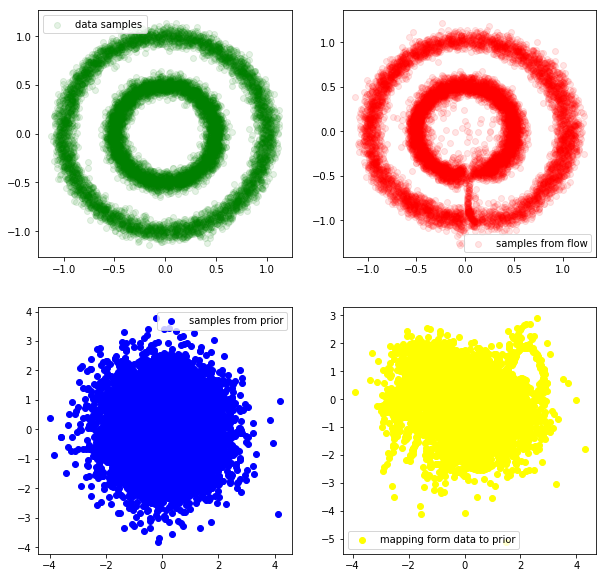

In [14]:
flow = train_and_draw(NETS_LAYERS_NUM, COUPLING_LAYERS_NUM, HIDDEN, nn.Tanh, init_weights_default, 10000)

iter 0: loss = 2.094
iter 500: loss = 1.517
iter 1000: loss = 1.244
iter 1500: loss = 0.865
iter 2000: loss = 0.898
iter 2500: loss = 0.785
iter 3000: loss = 0.978
iter 3500: loss = 0.699
iter 4000: loss = 0.696
iter 4500: loss = 0.913
iter 5000: loss = 0.652
iter 5500: loss = 0.740
iter 6000: loss = 0.617
iter 6500: loss = 0.958
iter 7000: loss = 0.651
iter 7500: loss = 0.898
iter 8000: loss = 0.823
iter 8500: loss = 0.670
iter 9000: loss = 0.622
iter 9500: loss = 0.658
iter 10000: loss = 0.801


/Users/icecream/code/venv3/lib/python3.7/site-packages/torch/distributions/distribution.py:133: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


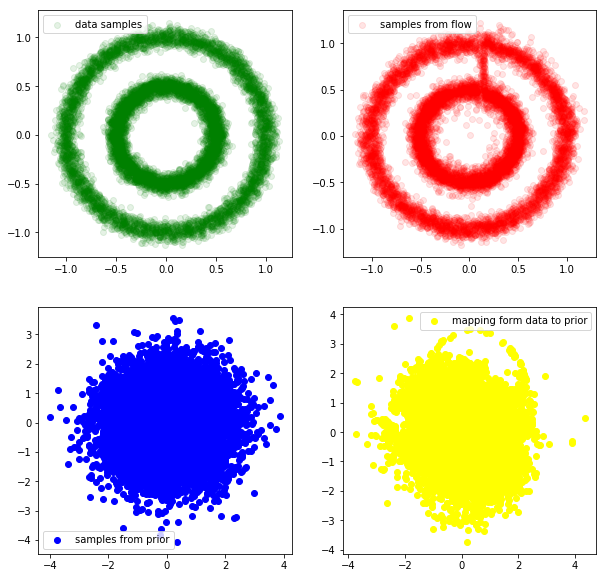

In [17]:
flow = train_and_draw(NETS_LAYERS_NUM, COUPLING_LAYERS_NUM, HIDDEN, nn.ReLU, init_weights_default, 10000)

iter 0: loss = 2.548
iter 500: loss = 1.476
iter 1000: loss = 1.352
iter 1500: loss = 0.942
iter 2000: loss = 0.866
iter 2500: loss = 0.690
iter 3000: loss = 0.713
iter 3500: loss = 0.724
iter 4000: loss = 0.665
iter 4500: loss = 0.659
iter 5000: loss = 0.658
iter 5500: loss = 0.687
iter 6000: loss = 0.750
iter 6500: loss = 0.671
iter 7000: loss = 0.768
iter 7500: loss = 0.620
iter 8000: loss = 0.799
iter 8500: loss = 0.850
iter 9000: loss = 0.739
iter 9500: loss = 0.788
iter 10000: loss = 0.661


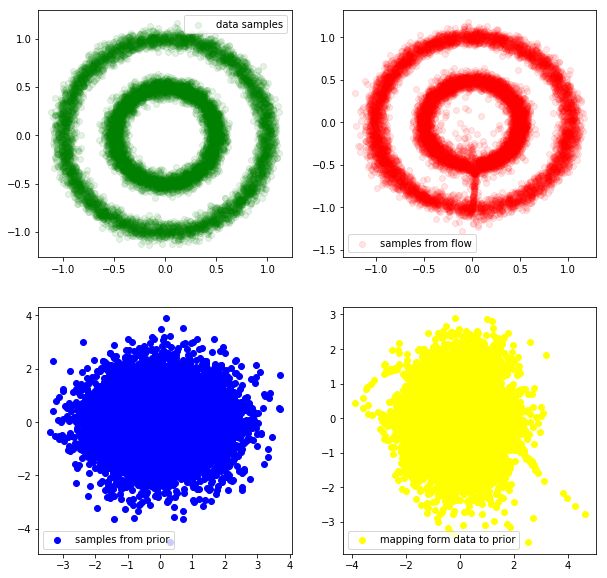

In [18]:
flow = train_and_draw(NETS_LAYERS_NUM, COUPLING_LAYERS_NUM, 64, nn.ReLU, init_weights_default, 10000)

iter 0: loss = 2.281
iter 500: loss = 1.665
iter 1000: loss = 1.501
iter 1500: loss = 1.405
iter 2000: loss = 1.210
iter 2500: loss = 1.162
iter 3000: loss = 0.993
iter 3500: loss = 0.950
iter 4000: loss = 1.073
iter 4500: loss = 0.968
iter 5000: loss = 0.838
iter 5500: loss = 0.924
iter 6000: loss = 0.852
iter 6500: loss = 0.906
iter 7000: loss = 0.791
iter 7500: loss = 0.830
iter 8000: loss = 0.818
iter 8500: loss = 0.751
iter 9000: loss = 0.773
iter 9500: loss = 0.986
iter 10000: loss = 0.786


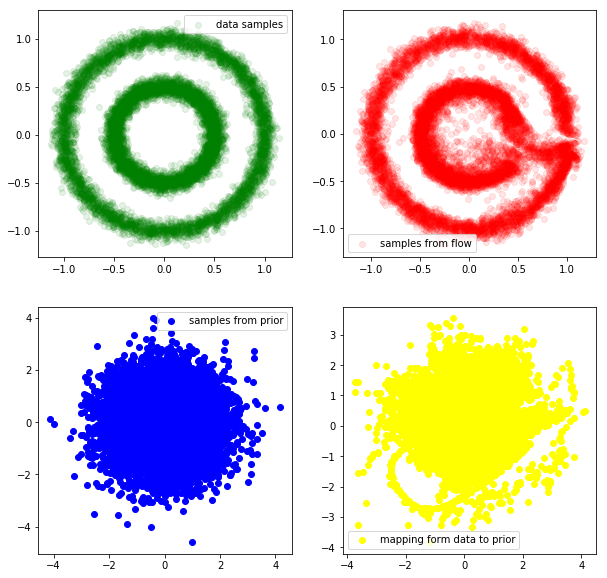

In [19]:
flow = train_and_draw(NETS_LAYERS_NUM, COUPLING_LAYERS_NUM, 32, nn.ReLU, init_weights_default, 10000)

iter 0: loss = 1.849
iter 500: loss = 1.492
iter 1000: loss = 1.303
iter 1500: loss = 1.024
iter 2000: loss = 0.849
iter 2500: loss = 0.765
iter 3000: loss = 0.711
iter 3500: loss = 0.687
iter 4000: loss = 0.673
iter 4500: loss = 0.749
iter 5000: loss = 0.669
iter 5500: loss = 0.775
iter 6000: loss = 0.701
iter 6500: loss = 0.873
iter 7000: loss = 0.676
iter 7500: loss = 0.713
iter 8000: loss = 0.715
iter 8500: loss = 0.651
iter 9000: loss = 0.686
iter 9500: loss = 0.614
iter 10000: loss = 0.610


/Users/icecream/code/venv3/lib/python3.7/site-packages/torch/distributions/distribution.py:133: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


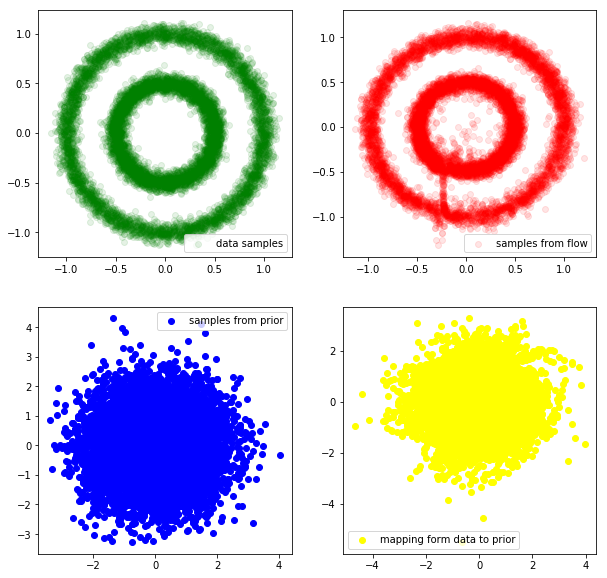

In [20]:
flow = train_and_draw(NETS_LAYERS_NUM, COUPLING_LAYERS_NUM, 64, nn.ReLU, init_weights, 10000)

iter 0: loss = 3.189
iter 500: loss = 1.467
iter 1000: loss = 1.420
iter 1500: loss = 0.809
iter 2000: loss = 0.866
iter 2500: loss = 0.725
iter 3000: loss = 0.730
iter 3500: loss = 0.661
iter 4000: loss = 0.705
iter 4500: loss = 0.744
iter 5000: loss = 0.684
iter 5500: loss = 0.796
iter 6000: loss = 0.746
iter 6500: loss = 0.721
iter 7000: loss = 0.618
iter 7500: loss = 0.754
iter 8000: loss = 0.621
iter 8500: loss = 0.621
iter 9000: loss = 0.625
iter 9500: loss = 0.521
iter 10000: loss = 0.753


/Users/icecream/code/venv3/lib/python3.7/site-packages/torch/distributions/distribution.py:133: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


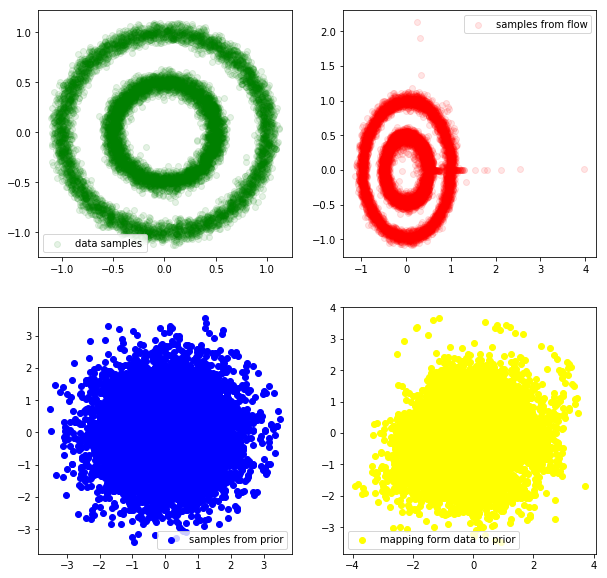

In [22]:
flow = train_and_draw(NETS_LAYERS_NUM, COUPLING_LAYERS_NUM, 64, nn.ReLU, init_weights_zero_bias, 10000)

Draw several plots: 
- samples from flow
- samples from prior
- data samples
- mapping form data to prior

The goal is to obtain figure similar to https://arxiv.org/abs/1605.08803

## Providde answerrs for the folowing questions:

1. What architecture worked better in your experiments?

I tried fully convolutional nets with different hidden layers sizes and different activations. Hidden size = 64 works well, but size 32 is not enough. Different activations perform roughly the same, but tanh seems to be slightlty better, then relu. Also I noticed, that weights initiation is rather important and can affect convergence speed.

2. Did you find what is important for stable training (initializations, nonlinearities, ...)?

In my experiments different architectures didn't help to stablize training. The best thing I did, was reducing lr. I also tried LBFGS, but it works very slowly. The was an idea of using l2 regularization, but I zabil, because of the need for coefficients selection.

3. How convergence speed (in iterations) depends on the complexity of architecture?

I need to note, that it is hard to detect the concrete moment, when the method has converged. Loss is rather unstable through the training. When it converges (complexity is enough), it converges in roughly the same iterations num. However, it takes more time to train more heavy models.

# Optional Research Assignments:

This assignment is optional. It will give you up to 2 additional points for one of the assignment.   
#### 1. VAE: 
Use normalizing flow to get more expressive $q(z\,|\,x)$,  https://arxiv.org/abs/1505.05770. TL;dr; use decoder to predict $z_0 \sim q_0(z_0|x)$, than use NF to obtain $z_k = f_k \circ \dots \circ f_1(z)$ sample from a more flexible distribution. Compare it with a conventional normal distribution, what is working better? Compare it with conventional VAE  that uses the same number of parameters as VAE with NF.

#### 2. Expressiveness: 
- Train the flow on an another 2d-dataset e.g., a mixture of 6 Gaussians (see figure 10, https://openreview.net/pdf?id=Hkg313AcFX). Is it possible to fit it with a normalizing flow? What is more beneficial increase size of s and t or increase the depth? Provide a justification for the answer e.g. plots.
- Use the flow to sample images from a more complex dataset, e.g. downsampled MNIST (8x8 should be fine). Do your findings remains the same? Also, provide plots.
